# <b>Project : YouTube Traffic</b>

<b>Student</b>:Myrian Koumgang Tekoboukitio 



The goal of this project is to develop an Unsupervised machine learning method(Clustering) to monitor changes in the YouTube CDN and determine the most important features for Supervised learning (Classification) when the CDN is in a stable situation (Week 1) or when major changes occur.



## <b>Task 1: Data Characterization/Preprocessing</b>


The goal of task 1 is to explore and get an insight of the dataset of the baseline week, identifying it's behavior on different levels.

The first thing we do is using data visualization techniques and statistical analysis to understand the behavior of the features we are provided with, so that afterwards we can reduce the amount of (useless) information in our dataset. 

The first week is provided with more than 300.000 rows of traffic flow. Our goal is develop an unsupervised method that must group the YouTube caches into clusters that represent the edge-nodes, 4 in this case. 
Since we have this information, the first thing we can do is plot the cumulative distribution function of server IP vs number of sent packets cache, to have the first informations on the cache flows of that week. 

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.cluster import contingency_matrix
from scipy.spatial.distance import euclidean
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score

In [3]:
######functions

def get_distinct(x):
    return len(set(x))


def init_tokens(df):
    tokens=dict()
    for i in range(df.shape[0]):
        s_ip=df.iloc[i]['s_ip']
        if s_ip not in tokens:
            tokens[s_ip]=len(tokens)
    return tokens
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    _contingency_matrix = contingency_matrix(y_true, y_pred)
    # return purity
    a = np.sum(np.amax(_contingency_matrix, axis=0))
    b = np.sum(_contingency_matrix)
    return a/b



def similarity_between_clusterings(x1, x2):
    return sum([euclidean(c1.ravel(), c2.ravel()) for c1, c2 in zip(x1, x2)]) / len(x1)

def calculate_differences(clusterings):
    n_clusterings = len(clusterings)
    differences = np.zeros((n_clusterings, n_clusterings))
    for i in range(n_clusterings):
        for j in range(i+1, n_clusterings):
            c1, c2 = clusterings[i], clusterings[j]
            maximum_number_label=min(c1.size,c2.size)
            differences[i, j] = differences[j, i] = similarity_between_clusterings(c1[:maximum_number_label], c2[:maximum_number_label])
    return differences


def find_week_most_different_from_baseline(differences, baseline_week_index=0):
    baseline_differences = differences[baseline_week_index]
   
    week_most_different_index = np.argmax(baseline_differences)
    return week_most_different_index

def confusion_matrix(y_true,y_pred):
    df=pd.DataFrame([x for x in zip(y_true,y_pred)],columns=['y_true','y_pred'])
    
    df[['samples']]=1
    confusion=pd.pivot_table(df,index='y_true',columns='y_pred',values='samples',aggfunc=sum)
    
    return confusion


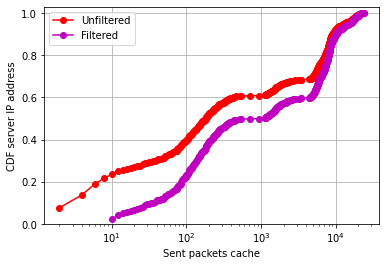

In [4]:
# Load dataset

features = pd.read_csv("dataset_Project1/Week_1.csv")
features['pkts']=1

#Apply the filter , dropping server IP with packets<=10 
#The cache level (aggregating all flows of same cache, i.e., sip e server IP address into a single row
ip_freq=features.value_counts('s_ip')
to_keep=ip_freq[ip_freq>=10].index
f_df=features[(features.s_ip.isin(to_keep))]
#CDF  server IP vs sent packets cache
cdf=features.value_counts('s_ip').reset_index().value_counts([0]).sort_index()
f_cdf=f_df.value_counts('s_ip').reset_index().value_counts([0]).sort_index()

features=features[(features.s_ip.isin(to_keep))]

# Plot the CDFs
plt.figure()
x=[x[0] for x in cdf.index]
y=np.cumsum(cdf)/np.sum(cdf)
f_x=[x[0] for x in f_cdf.index]
f_y=np.cumsum(f_cdf)/np.sum(f_cdf)

plt.plot(x,y,label='Unfiltered',marker='o',color='r')
plt.plot(f_x,f_y,label='Filtered',marker='o',color='m')
plt.xscale('log')
plt.ylim(0,1.03)
plt.xlabel('Sent packets cache')
plt.ylabel('CDF server IP address')
plt.grid()
plt.legend()

As we see from the plot, the red curve represent the CDF of the entire cache level flow, while the violet curve represent the filtered one, where we dropped the servers that sent less than 10 packet. Filtering can help in data characterization, by reducing the noise of the dataset. By only considering the server IP addresses that have sent at least 10 packets, we better identify the pattern and distribution of the number of packets sent by each server IP. This gives a more general representation of the data.

Now, we seek for seasonality in our data. With the help of the timestamp feature, we generate a plot of the number of packets (pkts) sent by each edge node over time, we can get an insight into the temporal patterns of the data and determine if the timestamp feature is discriminatory for the edge node, and furthermore if we need to filter the dataset in specif hours.

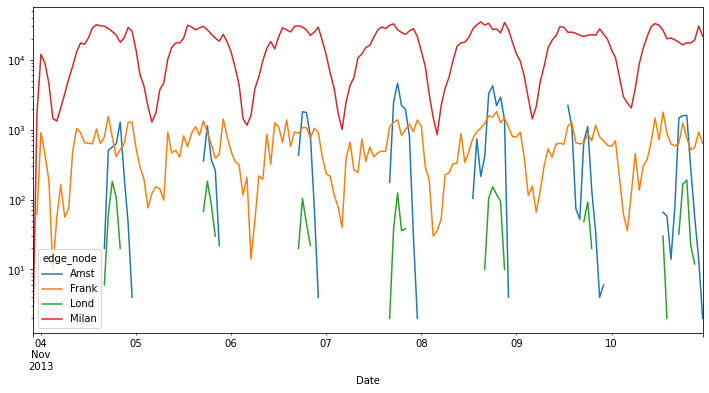

In [5]:
from datetime import datetime
# Convert the timestamp column to a datetime object
features['timestamp'] = pd.to_datetime(features['timestamp'], unit='ms')
# Resample the data by hour, summing the packets sent for each edge node
resampled = features.groupby(['edge_node', pd.Grouper(key='timestamp', freq='H')])['pkts'].sum()
# Unstack the dataframe to create a separate column for each edge node
resampled = resampled.unstack(level=0)
# Plot the data
resampled.plot(kind='line', figsize=(12, 6))
# Set the x-axis label to 'Date'
plt.xlabel('Date')
plt.yscale('log')
# Show the plot
plt.show()

In [6]:
# Create a new column that represents the time of day for each flow
#features['time_of_day'] = pd.cut(features['timestamp'].dt.hour, bins=[0, 6, 12, 18, 24], labels=['night', 'morning','afternoon', 'evening'])
print(features.shape)
# Filter the dataset to only include flows that occurred during certain time periods and at specific edge nodes
#features = features[(features['time_of_day'] == 'afternoon') | (features['time_of_day'] == 'morning')] #& (df['edge_node'].isin(['Milan', 'Frankfurt']))]
#print(features.shape)

(3023946, 11)


We can clearly see that the traffic flow has seasonality: Milan and Frankfurt operates the most from morning to midnight, while Amsterdam and London are active only during the evening. However, filtering the dataset according to this property of the flows (taking only the cache flows during the evening or taking only morning and afternoon) does not improve the performance of our algorithm, quite the contrary. This can be caused by the fact that by filtering the data, some patterns or features that could've been important for clustering might be removed or reduced. In addition, the clustering algorithm could be biased towards the patterns or features that were present in the filtered dataset, rather than capturing the full range of patterns or features present in the original dataset. So we decided to not exploit the presence of the timestamp.

# <b>Data exploration/Frequent pattern mining</b>
At this point, we filtered our dataset. Now, we can plot the cumulative distribution function on edge node level, to see which feature can be more representative to our goal. 

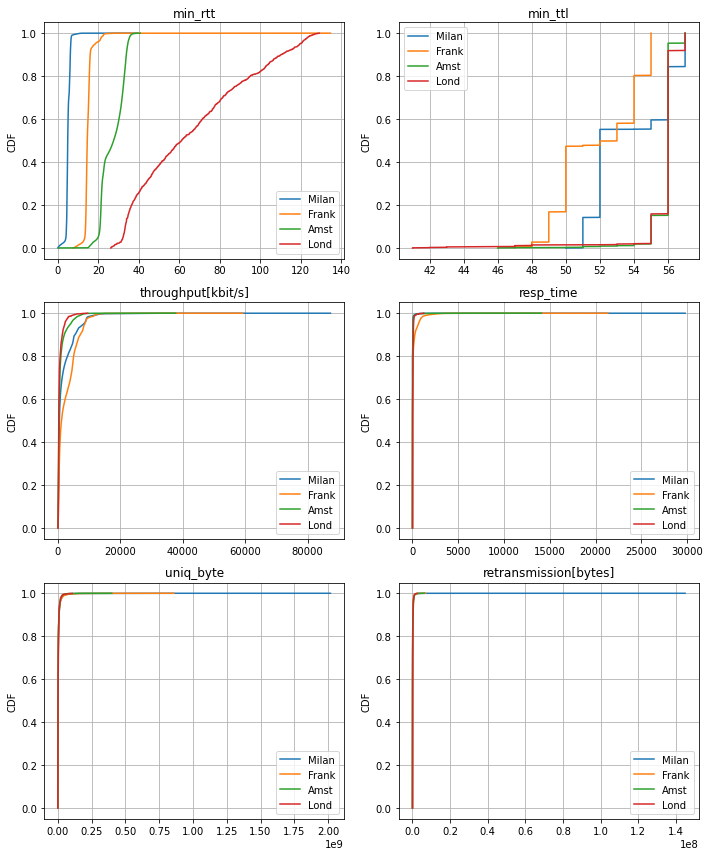

In [7]:
columns =["min_rtt","min_ttl","throughput[kbit/s]","resp_time","uniq_byte", "retransmission[bytes]"]

edge_node=[x for x in features.edge_node.unique()]

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 12))

for i, c in enumerate(columns):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    for s in edge_node:
        tmp = features[features.edge_node == s][c].values 
        ax.plot(sorted(tmp), [j/len(tmp) for j in range(len(tmp))], label=s)
    ax.legend()
    ax.set_title(c)
    ax.set_ylabel('CDF')
    ax.grid()

plt.tight_layout()
plt.show()
   

### From a preliminary analysis using data exploration techniques, we can see that there are features that have no discriminative ability for a specific edge-node group. Since they are not of use to characterize the desired flow level we remove them

#### None discriminative features for edge-node:

- resp_time
- uniq_byte
-retransmission[bytes]




(763, 12)
(763, 12)


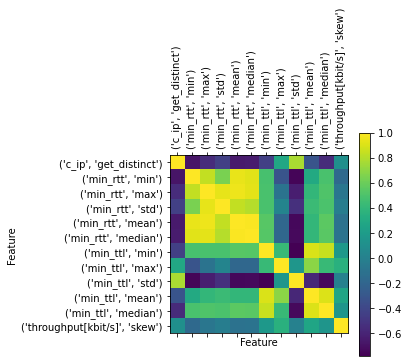

In [8]:
#features=features.drop(['throughput[kbit/s]','resp_time','uniq_byte','retransmission[bytes]'], axis=1)

cache_level = features.groupby(["s_ip"]).agg({"c_ip":get_distinct, 'min_rtt': ['min','max','std','mean','median'],
                                              'min_ttl':['min','max','std','mean', 'median'],
                                                "throughput[kbit/s]":["skew"],
                                              })
print(cache_level.shape)

#now we filter our dataset
cache_level = cache_level[cache_level.index.isin(to_keep)]
print(cache_level.shape)

corr = cache_level.corr()

# Visualizza la matrice di correlazione

plt.matshow(corr)
plt.xticks(np.arange(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(np.arange(len(corr.columns)), corr.columns)
plt.colorbar()
plt.xlabel("Feature")
plt.ylabel("Feature")
plt.show()


From the above data characterization task, because of the high correlation between some of the features we created, we decided to keep just some of them.

For min_rtt, we focused on the standard deviation and the median. The reason why we took this two statistics is pretty clear by looking both at the cumulative distribution and the correlation matrix, because we see that each edge_node has very different values on which the cumulative distribution reach 0.5, so the median seems a very good value that can descriminize the edge_nodes, and a similar property is present on the slopes of the curves, hence the different values of standard deviation.

For what concerns min_ttl, by looking both the correlation matrix, we decided to keep the minimum, because we can see that each edge_node distribution starts growing up for different values of ttl. The features median, mean and std can help discriminating the 4 distribution, which are likely to be more useful for predicting outcomes than the minimum and maximum values.

For the throughput, the decision to drop the other statistics, such as the mean and median, it's due to the fact that the cumulative distribution reaches 1 fast. This suggests that the throughput values are concentrated around a narrow range, and that the mean and median values may not be as informative as other values, like skewness, which can provide information about the typical range of throughput values and the presence of outliers, and the std, that can provide information about the stability of the network connection, and whether the throughput values are consistently high or low.


## <b>Task 2: Unsupervised Learning</b>

We prepare the data for clustering by aggregating features for each unique server ip (cache level) and keeping only the above explained selected features. The get_distinct function used for the c_ip column returns the number of distinct values, i.e., the number of distinct clients that exchanged information with that specific server ip.

The resulting dataframe tmp contains filtered server ip (server ip with atleast 10 packets) with the corresponding selected features. The GT dataframe contains the ground truth cluster labels grouped in cache level (this will be later used to compare the performance of our algorithm with the generated clustering results).

In [11]:
from sklearn.preprocessing import StandardScaler

features = pd.read_csv("dataset_Project1/Week_1.csv")

# Get X and y
tmp= features.groupby(["s_ip"]).agg({ "c_ip":get_distinct,'min_rtt': ['median','std'],
                                'min_ttl':['min','mean',"std",'median'],
                                     "throughput[kbit/s]":["skew",'std']#, 'throughput[kbit/s]':['std']
                                    }).fillna(.0)

tmp = tmp[tmp.index.isin(to_keep)]
#for each s_ip, we keep in a different dataset the GT labels. This is not used for the clustering obvioulsy. It's done just to
#see if the algorithm is workly properly.
GT = features.groupby(["s_ip"]).agg({'edge_node':pd.Series.mode})
print("Number of rows for the unfiltered grouped dataframe: ")
print(GT.shape[0], "\n")

GT = GT[GT.index.isin(to_keep)]
GT_dropped = GT.reset_index(drop=True).to_numpy()
X =  tmp.to_numpy()
# Scale Data
scaler = StandardScaler()
X_s = scaler.fit_transform(X)
print("Number of rows for the filtered grouped dataframe: ")

print(GT.shape[0])

Number of rows for the unfiltered grouped dataframe: 
975 

Number of rows for the filtered grouped dataframe: 
763


# <b>CLUSTERING ALGORITHMS


### <b>1 - K-MEANS with silhouette-based heuristic</b>

Performing K-means clustering on the dataset X_s, which contains the scaled features data for the caches. The aim is to cluster the caches into groups that represent the edge-nodes.We perform a grid search by computing the silhouette score for a range of K (number of clusters) values, from 3 to 19. K-means algorithm is run again using the optimal number of clusters (best_idx) determined from the silhouette score heuristic. The resulting clusters is assigned to week1_clustering_results

We calculate and print the unsupervised and supervised metrics, including the silhouette score, homogeneity score, and adjusted rand index (ARI) between the <b>predicted clusters</b> and the <b>ground truth labels</b>.

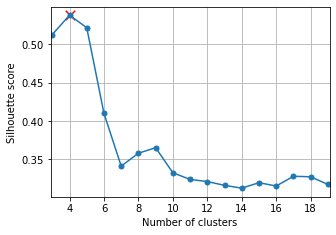

K-Means with 4 clusters
silhouette score: 0.54
Homogeneity: 0.85
ARI: 0.91


In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import (homogeneity_score, silhouette_score, adjusted_rand_score)

shs=[]
for n_cluster in range(3,20):
    
    kmeans=KMeans(n_clusters=n_cluster,random_state=15)
    c1_labels=kmeans.fit_predict(X_s)
    silhouette=silhouette_score(X_s,c1_labels)
    shs.append(silhouette)
    
best_idx=np.argmax(shs)+3

# Plot
plt.figure(figsize=(5,3.5))
plt.plot(range(3,20),shs,marker='o',markersize=5)
plt.scatter(best_idx,max(shs),color='r',marker='x',s=90)
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.xlim(2.9, 19.1) 
plt.show()

###########################
##Best K-MEANS from heuristic
###############################################################################
kmeans=KMeans(n_clusters=best_idx,random_state=15)
c1_labels_best=kmeans.fit_predict(X_s) #Get clusters ID
week1_clustering_results = np.array(c1_labels_best)

#Unsupervised metric
silhouette=silhouette_score(X_s,c1_labels_best)
# Supervised metric
ari=adjusted_rand_score(GT_dropped[:,0],week1_clustering_results)
homogeneity=homogeneity_score(GT_dropped[:,0],week1_clustering_results)

print(f'K-Means with {best_idx} clusters')
print(f'silhouette score: {silhouette:.2f}')
print(f'Homogeneity: {round(homogeneity,2)}')
print(f'ARI: {round(ari,2)}')


The above results show that the K-Means clustering algorithm with 4 clusters performed well on this dataset. This make perfectly sense since we have 4 distinct edge_node. The silhouette score of 0.54 indicates that the clusters are well separated from each other. The homogeneity score of 0.85 indicates that the members of each cluster belong to the same class. The adjusted Rand index (ARI) of 0.91 indicates that the clustering results are in high agreement with the ground truth labels. These high scores for homogeneity and ARI suggest that the clusters are accurate and well-formed, and that the K-Means algorithm is effective in grouping the caches into clusters that represent the edge-nodes.

### <b>2 - DBSCAN - Grid Search for epsilon and MinPts</b>

We perform a hyperparameter search using Grid Search to find the best parameters for the DBSCAN clustering algorithm. The Grid Search evaluates different combinations of eps and min_samples hyperparameters and returns the best combination that results in the highest silhouette score.
The output of the code shows the best combination of eps and min_samples hyperparameters, as well as the highest silhouette score achieved by the DBSCAN clustering 

DBSCAN with best parameters (0.96, 8) 
DBSCAN highest silhouette score: 0.44



Text(0.96, 8, 'X')

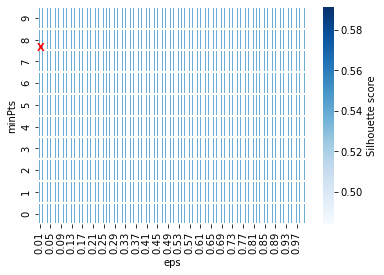

In [18]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering

shs=[]
best_score = 0
best_params = (0, 0)

for eps in np.arange(.01,1.01,.01):
    eps=round(eps,3)
    for min_samples in range(10):
        # Initialize and fit the DBSCAN model
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X_s)

        # generate cluster labels
        labels = dbscan.labels_

        # Evaluate the performance of the model
        #Unsupervised metric
        try:
            score = silhouette_score(X_s, labels)
        except:
            score =np.nan
        shs.append((eps,min_samples,silhouette))
        # Update the best values of eps and min_samples if the model's performance is better
        if score > best_score:
            best_score = score
            best_params = (eps, min_samples)

print(f'DBSCAN with best parameters { best_params} ')
print(f'DBSCAN highest silhouette score: {best_score:.2f}')
print()

##plot
gs=pd.DataFrame(shs,columns=['eps','minPts','sh'])
gs=pd.pivot_table(gs,columns='eps',index='minPts',values='sh',aggfunc=lambda x:x)
plt.figure(8)
sns.heatmap(gs, cmap='Blues', cbar_kws={'label':'Silhouette score'},linewidths=.005)
plt.gca().invert_yaxis()

best_row = best_params[1]
#best_col = np.where(np.arange(.01, 1.01, .01) == best_params[0])[0][0]
plt.annotate("X", (best_col, best_row), color="red", ha="center", fontweight="bold")

### <b>3 - HIERARCHICAL AGGLOMERATIVE CLUSTERING 4 Clusters and 3 different linkage</b>

We apply Agglomerative Clustering using three different linkage methods (single, complete, and average) and evaluates the performance of each method in terms of silhouette score, homogeneity, and ARI. The clustering is performed with 4 clusters, and the data is represented in a cosine distance matrix.
For each method, the code prints out the performance metrics, including Silhouette score, Homogeneity, and ARI, which indicate the quality of the clustering.
By comparing the results for each method, we can determine which linkage method performs better in clustering the data

In [18]:
for method in ['single','complete','average']:
    agglo=AgglomerativeClustering(n_clusters=4,linkage=method,affinity='cosine')
    
    c1_labels3=agglo.fit_predict(X_s)
    silhouette=silhouette_score(X_s,c1_labels3)
    homogeneity=homogeneity_score(labels_true=np.ravel(GT_dropped[:,0]), labels_pred=c1_labels3)
    ari=adjusted_rand_score(np.ravel(GT_dropped[:,0]), c1_labels3)
    print(f'Agglomerative clustering with 4 clusters -- {method} linkage')
    print(f'Silhouette: {round(silhouette,2)}')
    print(f'Homogeneity: {round(homogeneity,2)}')
    print(f'ARI: {round(ari,2)}')
    print()
    

Agglomerative clustering with 4 clusters -- single linkage
Silhouette: 0.35
Homogeneity: 0.5
ARI: 0.62

Agglomerative clustering with 4 clusters -- complete linkage
Silhouette: 0.49
Homogeneity: 0.57
ARI: 0.65

Agglomerative clustering with 4 clusters -- average linkage
Silhouette: 0.54
Homogeneity: 0.57
ARI: 0.68



### RESULTS

By looking at the results of the 3 algorithms, we can say that the best silhouette score is obtained both with k-means and Agglomerative clustering - average link. However, K-means reach very high scores of ARI and Homogeneity, thus we will use k-means as clustering algorithm.

### <b>PCA Visualization</b>

Index(['PC1', 'PC2', 'PC3'], dtype='object')


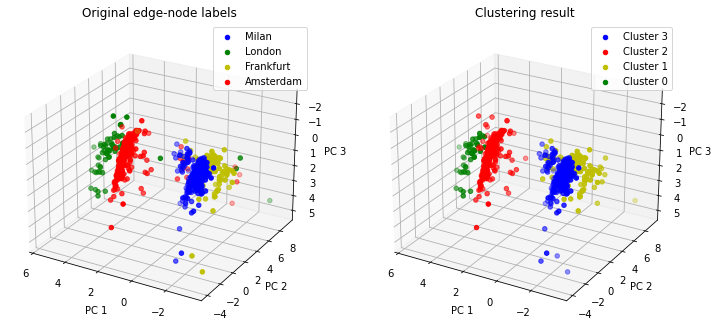

In [28]:
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder

tmp2 = tmp.copy()
tmp2["edge_node"] = 0
tmp2["edge_node"] = GT_dropped
#tmp2= tmp.append(GT_dropped)
tmp2.reset_index(drop=True, inplace=True)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_s)
PCA_df = pd.DataFrame(data = X_pca, columns = ['PC1', 'PC2','PC3'])
print(PCA_df.columns)


PCA_df["mode"] = GT_dropped
a = "mode"



PCA_df[a] = LabelEncoder().fit_transform(PCA_df[a])
PCA_df.head()

#idx1 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 1]
#idx2 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 2]
#idx3 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 3]
#idx0 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 0]


classes = [3,2,1,0]
colors = ['b','g','y','r']


fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
for clas, color in zip(classes, colors):
    
    ax.scatter(PCA_df.loc[PCA_df[a] == clas, 'PC1'], 
                PCA_df.loc[PCA_df[a] == clas, 'PC2'],
                PCA_df.loc[PCA_df[a] == clas, 'PC3'], 
                c = color)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend(['Milan', 'London','Frankfurt', 'Amsterdam'])
ax.set_title("Original edge-node labels")  
#Frank  = 1
#Amst = 0
#Lond = 2
#Milano = 3
ax.view_init(-155, 60)
PCA_df[("CLUSTERS")] = c1_labels_best

colors = ['b','r','y','g']
classes = [3,2,1,0]

ax = fig.add_subplot(1, 2, 2, projection='3d')

for clas, color in zip(classes, colors):
    
    ax.scatter(PCA_df.loc[PCA_df[("CLUSTERS")] == clas, 'PC1'], 
                PCA_df.loc[PCA_df[("CLUSTERS")] == clas, 'PC2'],
                PCA_df.loc[PCA_df[("CLUSTERS")] == clas, 'PC3'], 
                c = color)
    
plt.legend(['Cluster 3', 'Cluster 2','Cluster 1', 'Cluster 0'])
ax.set_title("Clustering result")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

ax.view_init(-155, 60)



We use principal component analysis (PCA) after performing clustering as a way to visualize the results of the algorithm and compare the ground truth labels with the clusters generated by the algorithm, allowing for a more comprehensive understanding of the data and the performance of the clustering algorithm. Although the clustering algorithm performed well and produced accurate results, it may not be able to achieve 100% accuracy due to the inherent complexity and variability of the data. Some samples may be inherently difficult to cluster and the algorithm may struggle to assign them to the correct group, resulting in a few misclassifications. Additionally, external factors such as measurement errors or unmeasured cofounding variables may introduce noise and make it challenging for the algorithm to cluster the data perfectly. Therefore, visualizing the results of the algorithm through a PCA plot can help identify the misclassified samples.

### <b>Visualize confusion matrices</b>

Text(0.5, 24.0, 'Predicted label')

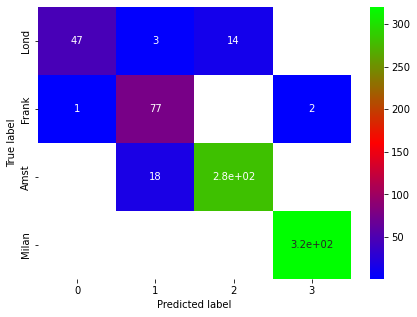

In [29]:
conf_matrix = confusion_matrix(GT_dropped[:,0], week1_clustering_results)

conf_matrix = conf_matrix.astype(float)

new_index = ['Lond', 'Frank','Amst', 'Milan']
conf_matrix = conf_matrix.reindex(new_index)
# Create the heatmap
fig = plt.figure(figsize=(7,5))
ax = sns.heatmap(conf_matrix, annot=True, cmap="brg")
plt.ylabel('True label')
plt.xlabel('Predicted label')


### <b>Loading weeks data</b>

In [30]:
week_data=[]
week2_clustering_results=0
week3_clustering_results=0
week4_clustering_results=0 
week5_clustering_results=0
week6_clustering_results=0

#Finding set of clusters for week 2 to 6
for week in range(2, 7):
    # Load the data for the current week
    week_data= pd.read_csv("dataset_Project1/Week_{}.csv".format(week))
    ip_freq=week_data.value_counts('s_ip')
    to_keep=ip_freq[ip_freq>=10].index
    
    tmp= week_data.groupby(["s_ip"]).agg({ "c_ip":get_distinct,'min_rtt': ['median','std'],
                                'min_ttl':['min','mean','std','median'],
                                     "throughput[kbit/s]":["skew",'std']#, 'throughput[kbit/s]':['std']
                                    }).fillna(.0)
    tmp = tmp[tmp.index.isin(to_keep)]
    
    #tmp.columns = tmp.columns.droplevel(0)
    #tmp.columns = [x for x in ["min_rtt","min_ttl","timestamp"]]
    
    
    X = tmp.to_numpy()
   
    # Scale Data
    scaler = StandardScaler()
    X_s = scaler.fit_transform(X)
    kmeans=KMeans(n_clusters=best_idx,random_state=15)
    
    # Return the cluster labels and centroids
    c1_labels=kmeans.fit_predict(X_s) #Get clusters ID
    week_clustering_results = np.array(c1_labels)
    

    # Store the clustering results for the current week
    exec("week{}_clustering_results = week_clustering_results".format(week))
    

## <b>Task 3: Clustering Evolution</b>

To study the evolution of clusters over time, we calculate the similarity between the clustering results of week 2 with respect to cluster C1 (baseline). Finally, we sum all of the distances to get an estimate of the overall difference between the two clustering results.Then we repeat this process for each pair of weeks and create a matrix with all of the distances.

This matrix is visualized using a heatmap to see how the distances between the weeks change over time.

Finally, we identify the week that is most different from the baseline week by finding the week with the highest distance from the baseline week in the distance matrix. 

You can then plot the clustering results for this week and compare them to the baseline week to see what changes have occurred.




In [31]:
clusterings = [week1_clustering_results, week2_clustering_results, week3_clustering_results, week4_clustering_results, week5_clustering_results,week6_clustering_results]

differences = calculate_differences(clusterings)

#print("Matrix of differences between each week's clustering result:")
#print(differences)
print('\n')

week_most_different = find_week_most_different_from_baseline(differences)


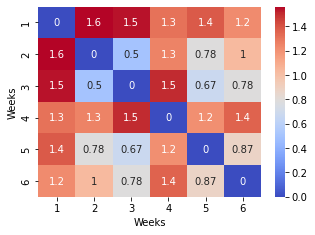

Week most different from baseline: week 2


In [32]:
plt.figure(figsize=(5,3.5))
sns.heatmap(differences, annot=True, cmap='coolwarm')
plt.xticks(np.arange(0.5, 6.5, 1), range(1, 7))
plt.yticks(np.arange(0.5, 6.5, 1), range(1, 7))

plt.xlabel('Weeks')
plt.ylabel('Weeks')
plt.show()
plt.close()
print(f"Week most different from baseline: week {week_most_different + 1}")

In [33]:
week_data2= pd.read_csv("dataset_Project1/Week_2.csv".format(week))



ip_freq=week_data2.value_counts('s_ip')
to_keep=ip_freq[ip_freq>=10].index


GT2 = week_data2.groupby(["s_ip"]).agg({'edge_node':pd.Series.mode})
GT2 = GT2[GT2.index.isin(to_keep)]
GT2_dropped = GT2.reset_index(drop=True).to_numpy()
print(GT2_dropped.shape)
week2_df= week_data2.groupby(["s_ip"]).agg({ "c_ip":get_distinct,'min_rtt': ['median','std'],
                            'min_ttl':['min','mean','std','median'],
                                 "throughput[kbit/s]":["skew",'std']#, 'throughput[kbit/s]':['std']
                                }).fillna(.0)
week2_df = week2_df[week2_df.index.isin(to_keep)]
print(week2_df.shape)

#tmp.columns = tmp.columns.droplevel(0)
#tmp.columns = [x for x in ["min_rtt","min_ttl","timestamp"]]


X2 = week2_df.to_numpy()

print(X2.shape)
# Scale Data
scaler = StandardScaler()
X2_s = scaler.fit_transform(X2)
kmeans=KMeans(n_clusters=best_idx,random_state=15)
week2_labels=kmeans.fit_predict(X2_s) #Get clusters ID

(520, 1)
(520, 9)
(520, 9)


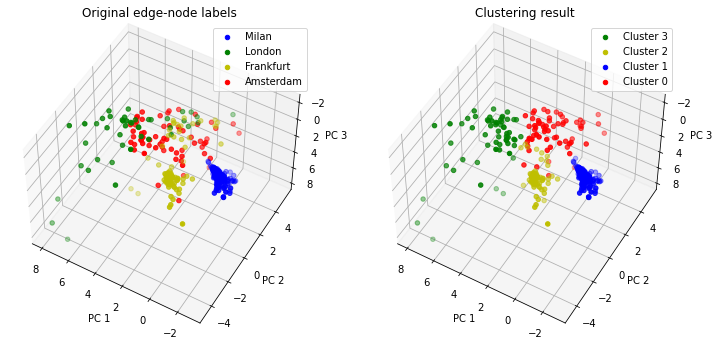

In [34]:
week2_df2 = week2_df.copy()
week2_df2["edge_node"] = 0
week2_df2["edge_node"] = GT2_dropped
#tmp2= tmp.append(GT_dropped)
week2_df2.reset_index(drop=True, inplace=True)

pca = PCA(n_components=3)
X2_pca = pca.fit_transform(X2_s)
PCA2_df = pd.DataFrame(data = X2_pca, columns = ['PC1', 'PC2','PC3'])



PCA2_df["mode"] = GT2_dropped
a = "mode"



PCA2_df[a] = LabelEncoder().fit_transform(PCA2_df[a])
PCA2_df.head()

#idx1 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 1]
#idx2 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 2]
#idx3 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 3]
#idx0 = [i for i in range(len(PCA_df)) if PCA_df['mode'][i] == 0]


classes = [3,2,1,0]
colors = ['b','g','y','r']


fig = plt.figure(figsize=(12, 10))

ax = fig.add_subplot(1, 2, 1, projection='3d')
for clas, color in zip(classes, colors):
    
    ax.scatter(PCA2_df.loc[PCA2_df[a] == clas, 'PC1'], 
                PCA2_df.loc[PCA2_df[a] == clas, 'PC2'],
                PCA2_df.loc[PCA2_df[a] == clas, 'PC3'], 
                c = color)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
plt.legend(['Milan', 'London','Frankfurt', 'Amsterdam'])
ax.set_title("Original edge-node labels")  
#Frank  = 1
#Amst = 0
#Lond = 2
#Milano = 3
ax.view_init(-130, 60)
PCA2_df[("CLUSTERS")] = week2_labels

colors = ['g','y','b','r']
classes = [3,2,1,0]

ax = fig.add_subplot(1, 2, 2, projection='3d')

for clas, color in zip(classes, colors):
    
    ax.scatter(PCA2_df.loc[PCA2_df[("CLUSTERS")] == clas, 'PC1'], 
                PCA2_df.loc[PCA2_df[("CLUSTERS")] == clas, 'PC2'],
                PCA2_df.loc[PCA2_df[("CLUSTERS")] == clas, 'PC3'], 
                c = color)
    
plt.legend(['Cluster 3', 'Cluster 2','Cluster 1', 'Cluster 0'])
ax.set_title("Clustering result")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

ax.view_init(-130, 60)


From the plot above, it seems that the clustering results for the most different week are not as accurate as for the baseline week. This could indicate that there have been significant changes in the YouTube CDN that are not well captured by the unsupervised learning method.

One possible explanation for the misclassification of samples could be the presence of outlier caches or edge-nodes in the most different week, which may not fit well into any of the clusters. It is also possible that the features that were used for clustering are not sensitive enough to capture the changes that occurred in the CDN during that week.


## <b>Task 4: Interpretation and Visualization</b>

To examine the importance of the features and how it changes depending on the week under consideration, we start by training and validating a Decision Tree model and a Random Forest model using data from the baseline week.

Next, we use the best hyperparameter configurations to train new models using data from the baseline week and the week that is most different from the baseline week. We then extract the feature importance of the four models and compare the feature rankings of the Decision Tree and Random Forest models for the baseline week and the week that is most different from the baseline week.

To compare the feature rankings,we create plots showing the relative importance of each feature for each model and week. You can then compare the plots to see how the importance of the features changes between the different weeks. This can help to understand how the importance of the features changes over time and how this may be related to changes in the edge-node infrastructure.

In [35]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def show_performance(best_report_train,best_report_val,best_confusion_train,best_confusion_val):
    print('TRAINING CLASSIFICATION REPORT')
    print(best_report_train)
    
    print('\n\nVALIDATION CLASSIFICATION REPORT')
    print(best_report_val)
    
    fig,axs=plt.subplots(1,2,figsize=(10,4))
    
    best_confusion_train=best_confusion_train.divide(best_confusion_train.sum(1),axis=0)
    sns.heatmap(best_confusion_train,cmap='Blues',annot=True,vmin=0,vmax=1,ax=axs[0],cbar_kws={'label':'Occurrences'})
    axs[0].set_xlabel('Prediction-Training')
    axs[0].set_ylabel('True')
    
    best_confusion_val=best_confusion_val.divide(best_confusion_val.sum(1),axis=0)
    sns.heatmap(best_confusion_val,cmap='Blues',annot=True,vmin=0,vmax=1,ax=axs[1],cbar_kws={'label':'Occurrences'})
    axs[1].set_xlabel('Prediction-Validation')
    axs[1].set_ylabel('True')
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    return

def run_DT(X_train_s,y_train,X_val_s,y_val):
    clf=DecisionTreeClassifier()
    clf.fit(X_train_s,y_train)
    y_train_pred=clf.predict(X_train_s)
    y_val_pred=clf.predict(X_val_s)
    
    best_clf=clf
    best_accuracy=accuracy_score(y_val,y_val_pred)
    best_report_train = classification_report(y_train, y_train_pred)
    best_report_val = classification_report(y_val, y_val_pred) 
    best_confusion_train = confusion_matrix(y_train, y_train_pred)
    best_confusion_val = confusion_matrix(y_val, y_val_pred)
    best_max_depth=5
    best_min_samples_split=5
    best_min_impurity_decrease=0.1

    for max_depth in range(5,21,5):
        for min_samples_split in range(5,21,5):
            for min_impurity_decrease in np.arange(0.1, 0.61, 0.1):
            
                
                clf = DecisionTreeClassifier(max_depth=max_depth,min_samples_split=min_samples_split,min_impurity_decrease=min_impurity_decrease)

                clf.fit(X_train_s, y_train)
                # Predict the labels for training and validation
                y_train_pred = clf.predict(X_train_s)
                y_val_pred = clf.predict(X_val_s)

                accuracy = accuracy_score(y_val, y_val_pred)
                
                
                if(best_accuracy < accuracy): 
                    best_clf = clf
                    best_accuracy = accuracy
                    best_report_train = classification_report(y_train, y_train_pred)
                    best_report_val = classification_report(y_val, y_val_pred) 
                    best_confusion_train = confusion_matrix(y_train, y_train_pred)
                    best_confusion_val = confusion_matrix(y_val, y_val_pred)
                    best_max_depth=max_depth
                    best_min_samples_split=min_samples_split
                    best_min_impurity_decrease=min_impurity_decrease
        

    print(best_clf)
    show_performance(best_report_train,best_report_val,best_confusion_train,best_confusion_val)
    
    return best_max_depth,best_min_samples_split,best_min_impurity_decrease

In [36]:
def run_RF(X_train_s, y_train,X_val_s,y_val):

    clf = RandomForestClassifier()
    clf.fit(X_train_s, y_train)
    y_train_pred = clf.predict(X_train_s)
    y_val_pred = clf.predict(X_val_s)

    best_clf = clf
    best_accuracy = accuracy_score(y_val, y_val_pred)
    best_report_train = classification_report(y_train, y_train_pred)
    best_report_val = classification_report(y_val, y_val_pred) 
    best_confusion_train = confusion_matrix(y_train, y_train_pred)
    best_confusion_val = confusion_matrix(y_val, y_val_pred)
    
    best_n_estimators=20
    best_max_depth=5
    best_min_samples_split=5
    best_min_impurity_decrease=0.1
   
    
 
    
    for n_estimators in range(20,101,20):
        for max_depth in range(5,21,5):
            for min_samples_split in range(5,21,5):
                for min_impurity_decrease in np.arange(0.1, 0.61, 0.15):
                    
                    clf = RandomForestClassifier(n_estimators=n_estimators,max_depth=max_depth,min_samples_split=min_samples_split,min_impurity_decrease=min_impurity_decrease)

                    clf.fit(X_train_s, y_train)
                    # Predict the labels for training and validation
                    y_train_pred = clf.predict(X_train_s)
                    y_val_pred = clf.predict(X_val_s)

                    accuracy = accuracy_score(y_val, y_val_pred)
                   
                    if(best_accuracy < accuracy): 
                        best_clf = clf
                        best_accuracy = accuracy
                        best_report_train = classification_report(y_train, y_train_pred)
                        best_report_val = classification_report(y_val, y_val_pred) 
                        best_confusion_train = confusion_matrix(y_train, y_train_pred)
                        best_confusion_val = confusion_matrix(y_val, y_val_pred)
                        best_n_estimators=n_estimators
                        best_max_depth=max_depth
                        best_min_samples_split=min_samples_split
                        best_min_impurity_decrease=min_impurity_decrease
                      
   
      
    
    print(best_clf)
    show_performance(best_report_train,best_report_val,best_confusion_train,best_confusion_val)
    
    
    return best_n_estimators,best_max_depth,best_min_samples_split,best_min_impurity_decrease

In [37]:
###Baseline--Find the best hyper-parameter configuration using a grid search approach (WEEK 1)
ip_freq=features.value_counts('s_ip')
to_keep=ip_freq[ip_freq>=10].index
    
X= features.groupby(["s_ip"]).agg({ "c_ip":get_distinct,'min_rtt': ['median','std'],
                                'min_ttl':['min','mean','std','median'],
                                     "throughput[kbit/s]":["skew",'std']#, 'throughput[kbit/s]':['std']
                                    }).fillna(.0)
X = X[X.index.isin(to_keep)]

y=week1_clustering_results
X_train,X_val,y_train,y_val=train_test_split(X, y,stratify=y, train_size=.7, random_state=15)
y_train,y_val=np.ravel(y_train),np.ravel(y_val)

scaler=StandardScaler()
scaler.fit(X_train)
X_train_s,X_val_s=scaler.transform(X_train),scaler.transform(X_val)

C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


DecisionTreeClassifier()
TRAINING CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00       206
           3       1.00      1.00      1.00       225

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534



VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       1.00      1.00      1.00        29
           2       0.99      1.00      0.99        89
           3       1.00      1.00      1.00        97

    accuracy                           1.00       229
   macro avg       1.00      0.98      0.99       229
weighted avg       1.00      1.00      1.00       229



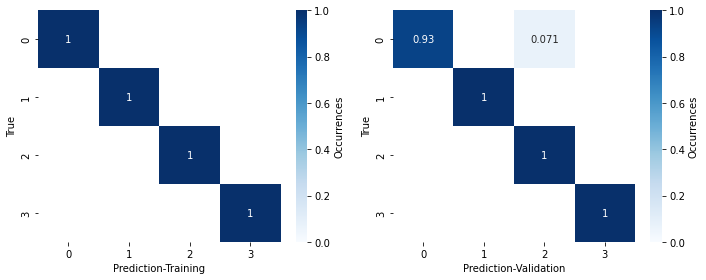

RandomForestClassifier()
TRAINING CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      1.00      1.00        69
           2       1.00      1.00      1.00       206
           3       1.00      1.00      1.00       225

    accuracy                           1.00       534
   macro avg       1.00      1.00      1.00       534
weighted avg       1.00      1.00      1.00       534



VALIDATION CLASSIFICATION REPORT
              precision    recall  f1-score   support

           0       1.00      0.93      0.96        14
           1       0.94      1.00      0.97        29
           2       0.99      0.99      0.99        89
           3       1.00      0.99      0.99        97

    accuracy                           0.99       229
   macro avg       0.98      0.98      0.98       229
weighted avg       0.99      0.99      0.99       229



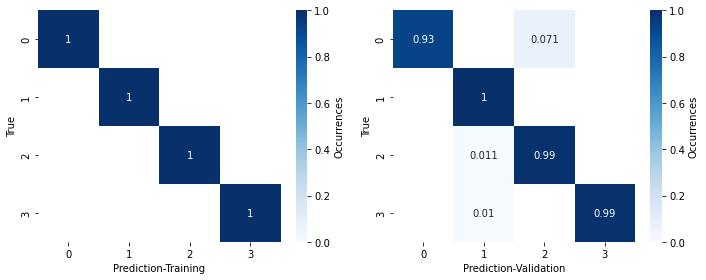

In [38]:
## Find the best hyper-parameter configuration Decision Tree model and a Random Forest model

best_max_depth_DT,best_min_samples_split_DT,best_min_impurity_decrease_DT=run_DT(X_train_s,y_train,X_val_s,y_val)
best_n_estimators_RF,best_max_depth_RF,best_min_samples_split_RF,best_min_impurity_decrease_RF=run_RF(X_train_s, y_train,X_val_s,y_val)

###Using the best hyper-parameter configurations, , train new models using data

clf_DT = DecisionTreeClassifier(max_depth=best_max_depth_DT,min_samples_split=best_min_samples_split_DT,min_impurity_decrease=best_min_impurity_decrease_DT)
clf_RF = RandomForestClassifier(n_estimators=best_n_estimators_RF,max_depth=best_max_depth_RF,min_samples_split=best_min_samples_split_RF,min_impurity_decrease=best_min_impurity_decrease_RF)

#Week 1
clf_DT.fit(X_train_s, y_train)
clf_RF.fit(X_train_s, y_train) 

clf_DT_Week_feature_importance1 = clf_DT.feature_importances_
clf_RF_Week_feature_importance1 = clf_RF.feature_importances_

In [39]:
##Week most different


clf_DT2 = DecisionTreeClassifier(max_depth=best_max_depth_DT,min_samples_split=best_min_samples_split_DT,min_impurity_decrease=best_min_impurity_decrease_DT)
clf_RF2 = RandomForestClassifier(n_estimators=best_n_estimators_RF,max_depth=best_max_depth_RF,min_samples_split=best_min_samples_split_RF,min_impurity_decrease=best_min_impurity_decrease_RF)

week_data= pd.read_csv("dataset_Project1/Week_{}.csv".format(week_most_different + 1))
ip_freq=week_data.value_counts('s_ip')
to_keep=ip_freq[ip_freq>=10].index
    
X= week_data.groupby(["s_ip"]).agg({ "c_ip":get_distinct,'min_rtt': ['median','std'],
                                'min_ttl':['min','mean','std','median'],
                                     "throughput[kbit/s]":["skew",'std']#, 'throughput[kbit/s]':['std']
                                    }).fillna(.0)
X = X[X.index.isin(to_keep)]
# Store the clustering results for the most different week
exec("y = week{}_clustering_results".format(week_most_different + 1))

X_train,X_val,y_train,y_val=train_test_split(X, y,stratify=y, train_size=.7, random_state=15)
y_train,y_val=np.ravel(y_train),np.ravel(y_val)

scaler=StandardScaler()
scaler.fit(X_train)
X_train_s,X_val_s=scaler.transform(X_train),scaler.transform(X_val)

clf_DT2.fit(X_train_s, y_train)
clf_RF2.fit(X_train_s, y_train)

clf_DT_Week_feature_importance2 = clf_DT2.feature_importances_
clf_RF_Week_feature_importance2 = clf_RF2.feature_importances_

C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Giovanni\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  warnings.warn(


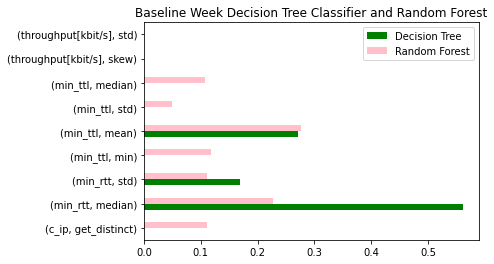

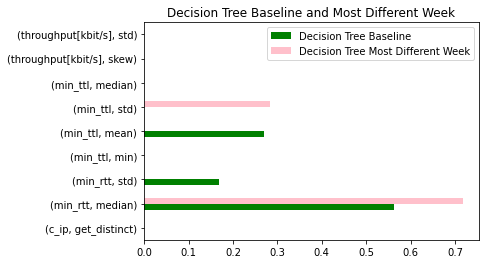

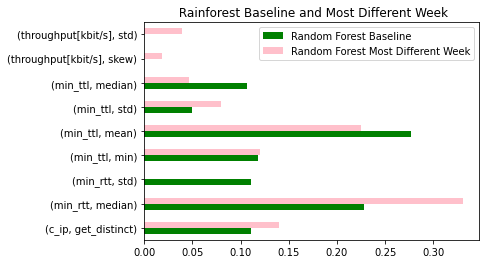

In [40]:
df = pd.DataFrame({'Decision Tree': np.array(clf_DT_Week_feature_importance1),'Random Forest': np.array(clf_RF_Week_feature_importance1)},index=np.array(X.columns))
df.plot.barh(title="Baseline Week Decision Tree Classifier and Random Forest", color={"green", "pink"});


df = pd.DataFrame({'Decision Tree Baseline': np.array(clf_DT_Week_feature_importance1),'Decision Tree Most Different Week': np.array(clf_DT_Week_feature_importance2)},index=np.array(X.columns))
df.plot.barh(title="Decision Tree Baseline and Most Different Week", color={"green", "pink"});

df = pd.DataFrame({'Random Forest Baseline': np.array(clf_RF_Week_feature_importance1),'Random Forest Most Different Week': np.array(clf_RF_Week_feature_importance2)},index=np.array(X.columns))
df.plot.barh(title=" Rainforest Baseline and Most Different Week", color={"green", "pink"});

It seems that the most important feature for both the baseline week and the most different week is the median of the minimum round-trip time (RTT). This suggests that changes in the RTT may be a key indicator of changes in the YouTube CDN, as we said earlier by looking at the CDF of the min_rtt.

It is also interesting to note that the mean of the minimum (TTL) is another important feature for the baseline week, but not for the most different week. This could indicate that changes in TTL are not as important for predicting changes in the CDN during the most different week.

The difference in feature importance rankings could be due to the different algorithms used in the two models, and the fact that decision trees tend to overfit to the data.

Overall, these results suggest that monitoring changes in the RTT can be an effective way to detect changes in the YouTube CDN, and that different features may be more or less important depending on the specific context.